In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import math
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from geopy.geocoders import Nominatim
import warnings

warnings.filterwarnings('ignore')
sns.set()

/opt/anaconda3/envs/model/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
watchedVid = pd.read_csv("../Dataset/watchedVideo.csv", index_col=0)
users = pd.read_csv("../Dataset/users.csv", index_col=0)
videos = pd.read_csv("../Dataset/videos.csv", index_col=0)
feeds = pd.read_csv("../Dataset/feeds.csv", index_col=0)

# Krikey Exploratory Data Analysis

Steps:
1. View User Data
* Create map of all users
* Create line plot of new users per month
2. View User Activity
* Look at user interactions with videos
* Create a scatter plot of average video views and videos created per user
* Look at user classes by gamers
3. View User Sharing
* Use OLS to test the average video view duration with the number of shares
* Create a scatter plot of average video view duration with the number of shares to look for trends. 

## User Data

This analysis is primarily concerned with finding key insights about User data. By looking at User data graphically and looking at trends over time is a good starting point as these broad analytics techniques can quickly find key insights. 

In [3]:
# Create users coordinates
coord = users.coordinates.str.replace("[()]", "", regex=True).str.split(",")
lat, long = coord.str
users["lat"] = lat.str.replace("['']", "", regex=True).astype(float)
users["long"] = long.str.replace("['']", "", regex=True).astype(float)

In [4]:
# Create map of all users 
m = folium.Map(location=[users.lat.mean(), users.long.mean()], tiles="cartodbpositron", zoom_start=2)

mc = MarkerCluster()
for idx, row in users.iterrows():
    mc.add_child(Marker([row['lat'], row['long']]))
m.add_child(mc)

m

Folium is a great tool for graphical visualizations, however it will not be interactive or viewable in github. This is a png of the starting view of the graph, but to view the interactive map the notebook will need to be opened in a personal notebook viewer such as jupyter notebooks or Google colab. 

<div>
    <img src="../images/Folium_Map.png" width="750"/>
</div>

In [5]:
# Get the Country and State features from the coordinates.
geolocator = Nominatim(user_agent="geoapiExercises")

# Just use the unique coordinates to reduce the computation time
unique_coord = users[["coordinates", "lat", "long"]].drop_duplicates().reset_index(drop=True)

state = []
country = []

for idx, row in unique_coord.iterrows():
    lat = str(row["lat"])
    long = str(row["long"])
    
    location = geolocator.reverse(lat+","+long, language='en')
    
    address = location.raw["address"]
    
    state.append(address.get("state", ""))
    country.append(address.get("country", ""))

loc_df = pd.DataFrame({"State": state, "Country": country})
unique_coord = pd.concat([unique_coord, loc_df], axis=1)
unique_coord.head()

,coordinates,lat,long,State,Country
0,"('36.76775', '2.95924')",36.76775,2.95924,Algiers,Algeria
1,"('43.71032', '-1.05366')",43.71032,-1.05366,New Aquitaine,France
2,"('51.26', '-2.1875')",51.26000,-2.18750,England,United Kingdom
3,"('40.65538', '-74.38987')",40.65538,-74.38987,New Jersey,United States
4,"('35.61452', '-88.81395')",35.61452,-88.81395,Tennessee,United States


In [6]:
# Join the Country and State features to the users data
users = users.merge(unique_coord, left_on="coordinates", right_on="coordinates", how="inner")
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1000 non-null   object 
 1   created_at   1000 non-null   object 
 2   class        1000 non-null   object 
 3   coordinates  1000 non-null   object 
 4   lat_x        1000 non-null   float64
 5   long_x       1000 non-null   float64
 6   lat_y        1000 non-null   float64
 7   long_y       1000 non-null   float64
 8   State        1000 non-null   object 
 9   Country      1000 non-null   object 
dtypes: float64(4), object(6)
memory usage: 85.9+ KB


In [7]:
# Create a month joined feature from the created_at user feature. 
users["created_at"] = pd.to_datetime(users["created_at"], format="%Y-%m-%d %H:%M:%S")
users["month"] = users.created_at.dt.month

new_users = pd.pivot_table(users, values="id", index="Country", columns="month", aggfunc="count").fillna(0)
new_users["sum"] = new_users.sum(axis=1)

new_users.sort_values("sum", ascending=False).head(10)

month,1,2,3,4,5,6,7,8,9,10,11,12,sum
Country,,,,,,,,,,,,,
United States,16.0,15.0,13.0,14.0,15.0,9.0,17.0,12.0,8.0,11.0,16.0,3.0,149.0
India,5.0,5.0,1.0,5.0,5.0,3.0,11.0,7.0,3.0,12.0,6.0,4.0,67.0
Russia,4.0,4.0,7.0,4.0,6.0,3.0,4.0,6.0,9.0,7.0,7.0,2.0,63.0
China,2.0,5.0,7.0,5.0,3.0,2.0,9.0,6.0,5.0,2.0,6.0,3.0,55.0
Brazil,1.0,5.0,2.0,6.0,1.0,6.0,8.0,8.0,5.0,2.0,7.0,1.0,52.0
Germany,4.0,2.0,2.0,2.0,9.0,1.0,5.0,6.0,4.0,4.0,6.0,3.0,48.0
United Kingdom,4.0,2.0,5.0,4.0,3.0,8.0,4.0,3.0,0.0,4.0,4.0,0.0,41.0
Italy,0.0,4.0,2.0,1.0,4.0,3.0,5.0,2.0,3.0,0.0,4.0,4.0,32.0
France,2.0,1.0,1.0,3.0,2.0,3.0,0.0,1.0,5.0,2.0,5.0,4.0,29.0


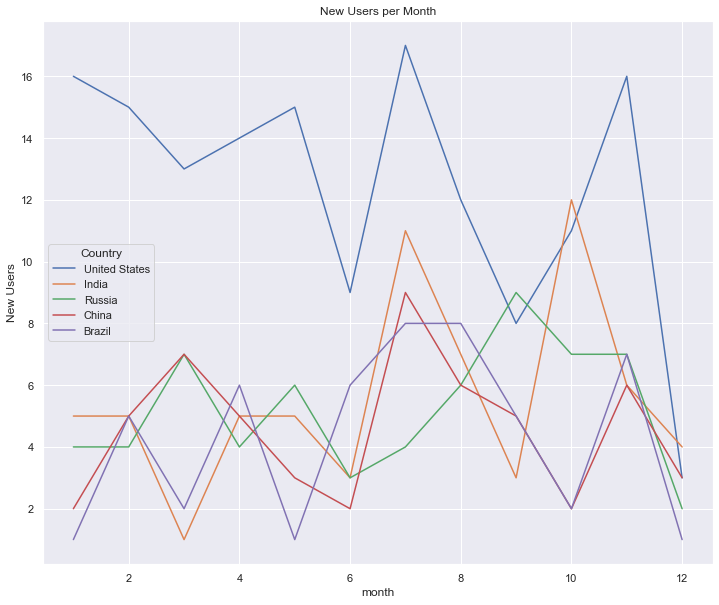

In [9]:
# Create a plot to show the changes in new users per month by the top 5 countries.
country_month_users = new_users.sort_values("sum", ascending=False).head(5).T
country_month_users.iloc[:-1].plot(grid=True, figsize=(12, 10))

plt.ylabel("New Users")
plt.title("New Users per Month")

plt.savefig("../images/NewUsersPerMonth.png")
plt.show()

## User Activity

After finding and visualizing the countries with the most users, it will be interesting to view the activity by these users such as average videos created per user and average video views per user. It may be interesting to see the trends of these users and how they differ from country to country.

In [10]:
# Create a series of the videos created count per country.
users_videos = users.merge(videos, left_on="id", right_on="creator", suffixes=('_u', '_v'))

created_videos_country = users_videos.groupby("Country").count()
created_videos_count = created_videos_country["id_u"].sort_values(ascending=False)

In [11]:
# Create a series of the videos viewed count per country.
users_watchedVid = users.merge(watchedVid, left_on="id", right_on="userId", suffixes=('_u', '_wv'))

watchedVid_country = users_watchedVid.groupby("Country").count()
watchedVid_count = watchedVid_country["id"].sort_values(ascending=False)

In [12]:
# Join these series along with the total user counts.
activity_counts = pd.concat([new_users["sum"], created_videos_count, watchedVid_count],
                            axis=1, join="inner")
activity_counts.columns = ["users", "created_videos", "watched_videos"]

# Create the average videos created and watched features. 
activity_counts["avg_created"] = activity_counts["created_videos"] / activity_counts["users"]
activity_counts["avg_watched"] = activity_counts["watched_videos"] / activity_counts["users"]

activity_counts.sort_values("users", ascending=False).head(10)

,users,created_videos,watched_videos,avg_created,avg_watched
Country,,,,,
United States,149.0,760,7463,5.100671,50.087248
India,67.0,330,3427,4.925373,51.149254
Russia,63.0,307,3226,4.873016,51.206349
China,55.0,274,2763,4.981818,50.236364
Brazil,52.0,250,2621,4.807692,50.403846
Germany,48.0,254,2437,5.291667,50.770833
United Kingdom,41.0,231,2071,5.634146,50.512195
Italy,32.0,174,1586,5.437500,49.562500
France,29.0,130,1405,4.482759,48.448276


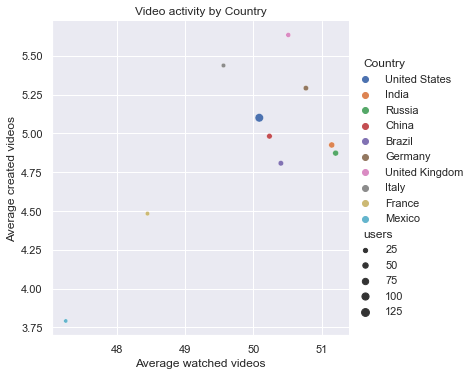

In [19]:
# Create a graph comparing the average created videos and watched videos of the top 10 countries. 
top10 = activity_counts.sort_values("users", ascending=False).head(10)
sns.relplot(y="avg_created", x="avg_watched", data=top10, hue="Country", size="users")

plt.title("Video activity by Country")
plt.xlabel("Average watched videos")
plt.ylabel("Average created videos")

plt.savefig("../images/VideoActivityByCountry.png")
plt.show()

It is interesting to find that the average watched videos and created videos are relatively similar across the top countries. This shows that user video activity hardly varies by country. 

Gaming is another important aspect of the app and it would be interesting how the top gaming countries compared to the top countries in users. 

In [14]:
user_class = pd.pivot_table(users, index="Country", columns="class", values="id", aggfunc="count")

user_class = user_class.fillna(0)
user_class["sum"] = user_class.sum(axis=1)
user_class["total_gamers"] = user_class["Gamer"]+user_class["Super Gamer"]
user_class["gamer_perc"] = user_class["total_gamers"]/user_class["sum"]

user_class.sort_values("total_gamers", ascending=False).head(10)

class,Creator,Gamer,Super Creator,Super Gamer,Viewer,sum,total_gamers,gamer_perc
Country,,,,,,,,
United States,40.0,26.0,32.0,25.0,26.0,149.0,51.0,0.342282
Russia,8.0,14.0,11.0,20.0,10.0,63.0,34.0,0.539683
India,16.0,16.0,9.0,17.0,9.0,67.0,33.0,0.492537
Brazil,13.0,11.0,6.0,12.0,10.0,52.0,23.0,0.442308
United Kingdom,5.0,10.0,6.0,11.0,9.0,41.0,21.0,0.512195
China,9.0,10.0,12.0,10.0,14.0,55.0,20.0,0.363636
Germany,8.0,9.0,11.0,9.0,11.0,48.0,18.0,0.375000
France,3.0,5.0,8.0,8.0,5.0,29.0,13.0,0.448276
Indonesia,6.0,5.0,1.0,8.0,3.0,23.0,13.0,0.565217


It is interesting to see that most of the top countries are the same, except Indonisia is in this top 10 countries list replacing Italy. 

## User Sharing

After finding that the viewing and creation hardly varies across Countries. Looking into how the percentage of a video viewed relates to the number of video shares may provide some insight. 

In [15]:
# Merge the watchedVideo, videos, and users tables together to gather all the data needed for this analysis. 
video_activity = watchedVid.merge(videos, left_on="videoId", right_on="id", suffixes=('_wv', '_v')).\
merge(users, left_on="creator", right_on="id", suffixes=('_v', '_u'))

# Only take the features needed for the analysis.
viewing_perc = video_activity[["videoId", "creator", "Country", "num_shares", "duration_wv", "duration_v"]]

# Get the average viewing duration for each video.
avg_view_time = viewing_perc.groupby("videoId").mean()["duration_wv"].reset_index()

# Join the average viewing duration to the main table. 
viewing_perc = viewing_perc.merge(avg_view_time, on="videoId")

# Create the average viewing percentage.
viewing_perc["avg_view_percent"] = viewing_perc["duration_wv_y"]/viewing_perc["duration_v"]

In [16]:
# Extract all necessary variables and drop duplicate values. 
viewing_perc = viewing_perc[["videoId", 
                             "Country", 
                             "num_shares", 
                             "duration_wv_y", 
                             "duration_v", 
                             "avg_view_percent"]].drop_duplicates()

# Only use data from the countries in the top 10 number of users.
mask = viewing_perc["Country"].isin(top10.T.columns) 
viewing_perc = viewing_perc[mask]

viewing_perc.sort_values("num_shares", ascending=False).head(10)

,videoId,Country,num_shares,duration_wv_y,duration_v,avg_view_percent
36867,b602da3f-c476-4f3f-874b-e01694783c50,Russia,20,4.478889,5.19,0.862984
32250,d704467b-888e-4bb2-a737-2be5f4f76f3e,Italy,20,3.058000,4.26,0.717840
15783,973246eb-00c8-4e79-aec2-10f10049def6,Brazil,20,2.674615,4.04,0.662034
49492,71f66a26-f375-4d0f-9358-a07a3ee24565,Germany,20,5.845000,6.72,0.869792
21030,f9f15067-7447-410b-b420-38ccb039b5ce,India,20,2.261818,3.37,0.671163
46757,a3499067-4d91-42c9-bb04-9243768866c7,Russia,20,4.786000,6.77,0.706942
44679,ac3c7351-9520-418d-a60d-dfde81aebcc1,Brazil,20,3.159000,3.34,0.945808
32627,bb1dd1be-47eb-4293-8670-a8a89aa03577,Germany,20,5.307000,6.12,0.867157
2224,8d9a3139-9963-45b4-9740-159b3e68a1b2,Germany,20,3.305000,4.19,0.788783
32598,11708f0a-5614-409c-b130-7439c998a94e,Germany,20,1.751000,2.17,0.806912


In [17]:
X = viewing_perc[["avg_view_percent"]]
y = viewing_perc["num_shares"]
X = sm.add_constant(X)

# Conduct a linear regression test to look for coorelation and statistical significance. 
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             num_shares   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.08161
Date:                Thu, 28 Apr 2022   Prob (F-statistic):              0.775
Time:                        03:59:06   Log-Likelihood:                -8990.9
No. Observations:                2801   AIC:                         1.799e+04
Df Residuals:                    2799   BIC:                         1.800e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.1803      0.802  

The valuable insights from this table are the R-squared (correlation) and the P>|t| value (statistical significance). Both of these values show there is likely no correlation between average video view duration and the number of shares. And that the average video view time likely doesn't have statistical significance. 

The graph below shows this better as the number of video shares appears to be random even by the country in which the video was created. 

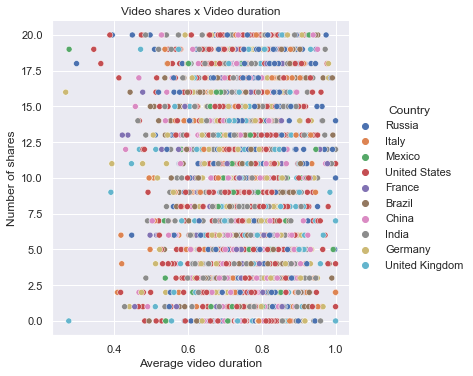

In [18]:
# Create a graph to show the relationship of average view duration and the number of video shares. 
sns.relplot(data=viewing_perc, x="avg_view_percent", y="num_shares", hue="Country")

plt.title("Video shares x Video duration")
plt.xlabel("Average video duration")
plt.ylabel("Number of shares")

plt.savefig("../images/VideoSharesXVideoDuration.png")
plt.show()